<a href="https://colab.research.google.com/github/ajaysaikiran2208/Natural-Language-Processing/blob/main/Pre_Training_and_Fine_Tuning_of_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-Training and Fine-Tuning BERT Models

#The architecture of BERT

**BERT** introduces **bidirectional attention to transformer models** . Bidirectional attention requires many other changes to the original Transformer model.

#The encoder stack

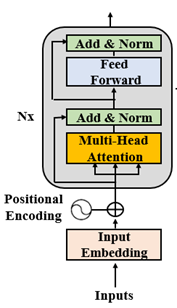

The BERT model does not use decoder layers. A BERT model has an encoder stack
but no decoder stacks. The masked tokens (hiding the tokens to predict) are in the attention layers of the encoder.

BERT encoder layers are larger than the original Transformer model.

Two BERT models can be built with the encoder layers:

      1.BERTbase which contains a stack of N=12 encoder layers,dimensions of head=768,A multi-head attention sublayer containes A=12 heads[Dimensions of each head is same as transformer i.e: 64]

      2.BERTlarge which contains a stack N=24 encoder layers,dimensions=1024,A multi-head attention sublayers A=16[Dimensions of each head is same as transformer i.e: 64]

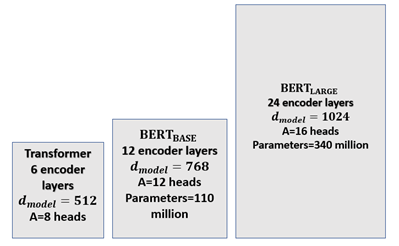

Size and dimensions play an essential role in BERT-style pretraining. BERT models are like humans. BERT models produce better results with more working memory(dimensions), and more knowledge (data). Large transformer models that learn large amounts of data will pretrain better for downstream NLP tasks.

#Pretraining and fine-tuning a BERT model

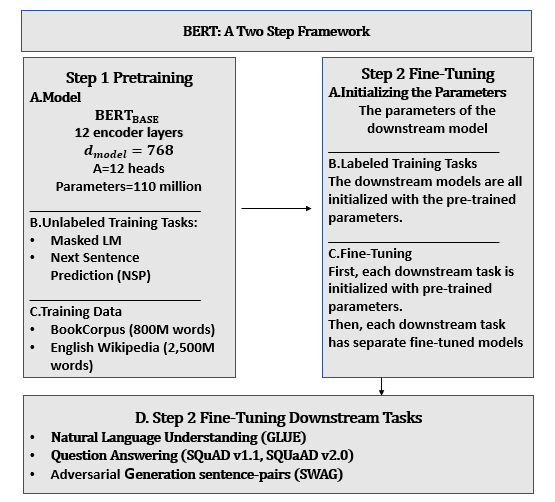

#Fine-tuning BERT

We will fine-tune a BERT model to predict the downstream task of
**Acceptability Judgements** and measure the predictions with the Matthews Correlation
Coefficient (MCC).

#Activating the GPU

Pretraining a multi-head attention transformer model requires the parallel
processing GPUs can provide.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Installing the Hugging Face PyTorch interface for BERT

Hugging Face provides a pretrained BERT model. Hugging Face developed a base
class named PreTrainedModel. By installing this class, we can load a model from a
pretrained model configuration.
Hugging Face provides modules in TensorFlow and PyTorch.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.5MB 6.7MB/s 
     |████████████████████████████████| 3.3MB 37.2MB/s 
     |████████████████████████████████| 901kB 53.4MB/s 


#Importing the modules

We will import the pretrained modules required, such as the pretrained BERT
tokenizer and the configuration of the BERT model. The BERTAdam optimizer is
imported along with the sequence classification module

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

A nice progress bar module is imported from tqdm

In [ ]:
from tqdm import tqdm, trange

We can now import the widely used standard Python modules

In [ ]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

#Specifying CUDA as the device for torch

We will now specify that torch uses the **Compute Unified Device Architecture**
(CUDA) to put the parallel computing power of the NVIDIA card to work for our
multi-head attention model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

#Loading the dataset

In [ ]:
df = pd.read_csv("/content/in_domain_train.tsv", delimiter='\t', header=None,
names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

Each sample in the .tsv files contains four tab-separated columns:

• Column 1: the source of the sentence (code)

• Column 2: the label (0=unacceptable, 1=acceptable)

• Column 3: the label annotated by the author

• Column 4: the sentence to be classified

In [ ]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


Creating sentences, label lists, and adding
BERT tokens

In [ ]:
#@ Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values
# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [73]:
labels.shape

(516,)

#Activating the BERT tokenizer

In this section, we will initialize a pretrained BERT tokenizer. This will save the time
it would take to train it from scratch.

The program selects an uncased tokenizer[BERT base model (uncased) Pretrained model on English language using a masked language modeling (MLM) objective], activates it, and displays the first
tokenized sentence:

In [78]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'somebody', 'just', 'left', '-', 'guess', 'who', '.', '[SEP]']


#Processing the data

In [ ]:

# Set the maximum sequence length. The longest sequence in our trainingset is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",truncating="post", padding="post")

In [79]:
input_ids

array([[ 101, 8307, 2074, ...,    0,    0,    0],
       [ 101, 2027, 3555, ...,    0,    0,    0],
       [ 101, 2065, 3520, ...,    0,    0,    0],
       ...,
       [ 101, 2198, 4149, ...,    0,    0,    0],
       [ 101, 2198, 5412, ...,    0,    0,    0],
       [ 101, 2198, 5720, ...,    0,    0,    0]])

The sequences have been processed and now the program creates the attention
masks.

#Creating attention masks

We padded the sequences in the previous
cell. But we want to prevent the model from performing attention on those padded
tokens!
The idea is to apply a mask with a value of 1 for each token, which will be followed
by 0s for padding:

In [ ]:
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [80]:
seq_mask

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

#Splitting data into training and validation sets

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels =train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,input_ids,random_state=2018, test_size=0.1)

#Converting all the data into torch tensors

The fine-tuning model uses torch tensors. The program must convert the data into torch tensors:

In [ ]:
# Torch tensors are the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#Selecting a batch size and creating an iterator

In this cell, the program selects a batch size and creates an iterator. The iterator is a
clever way of avoiding a loop that would load all the data in memory. The iterator,
coupled with the torch DataLoader, can batch train huge datasets without crashing
the memory of the machine.

In this model, the batch size is 32:

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks,
validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#BERT model configuration

The program now initializes a BERT uncased configuration

In [ ]:
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
from transformers import BertModel, BertConfig
configuration = BertConfig()
# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



attention_probs_dropout_prob: 0.1 applies a 0.1 dropout ratio to the
attention probabilities.

• hidden_act: "gelu" is a non-linear activation function in the encoder. It is a Gaussian Error Linear Units activation function. The input is weighted by its magnitude, which makes it non-linear.

• hidden_dropout_prob: 0.1 is the dropout probability applied to the fully
connected layers. Full connections can be found in the embeddings, encoder,
and pooler layers. The pooler is there to convert the sequence tensor for
classification tasks, which require a fixed dimension to represent the
sequence. The pooler will thus convert the sequence tensor to (batch size,
hidden size), which are fixed parameters.

• hidden_size: 768 is the dimension of the encoded layers and also the pooler layer.

• initializer_range: 0.02 is the standard deviation value when initializing the weight matrices.
• intermediate_size: 3072 is the dimension of the feed-forward layer of the
encoder.

• layer_norm_eps: 1e-12 is the epsilon value for layer normalization layers.

• max_position_embeddings: 512 is the maximum length the model uses.

• model_type: "bert" is the name of the model.

• num_attention_heads: 12 is the number of heads.

• num_hidden_layers: 12 is the number of layers.

• pad_token_id: 0 is the ID of the padding token to avoid training padding
tokens.

• type_vocab_size: 2 is the size of the token_type_ids, which identify the
sequences. For example, "the dog[SEP] The cat.[SEP]" can be represented
with 6 token IDs: [0,0,0, 1,1,1].

• vocab_size: 30522 is the number of different tokens used by the model to
represent the input_ids.

#Loading the Hugging Face BERT uncased base model

In [ ]:
from transformers import pipeline
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#Optimizer grouped parameters

The program will now initialize the optimizer for the model's parameters. Finetuning
a model begins with initializing the pretrained model parameter values (not
their names).

The parameters of the optimizer include a weight decay rate to avoid overfitting, and
some parameters are filtered.

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

In [ ]:
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.1},{'params': [p for n, p in param_optimizer if any(nd in n for nd in
no_decay)],'weight_decay_rate': 0.0}
]

In [ ]:
!pip install transformers
from transformers import BertModel
BertModel.from_pretrained # good to go

<bound method PreTrainedModel.from_pretrained of <class 'transformers.models.bert.modeling_bert.BertModel'>>

In [ ]:
!pip install pytorch_pretrained_bert==0.4.0

In [ ]:
from transformers.models.bert.modeling_bert import BertLayer

#The hyperparameters for the training loop

The hyperparameters for the training loop are critical, though they seem innocuous.
Adam will activate weight decay and also go through a warm-up phase, for example.

The learning rate (lr) and warm-up rate (warmup) should be set to a very small value
early in the optimization phase and gradually increase after a certain number of
iterations. This avoids large gradients and overshooting the optimization goals.

In [ ]:
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

The program adds an accuracy measurement function to compare the predictions to
the labels:

In [ ]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

#The training loop

The training loop follows standard learning processes. The number of epochs is set
to 4, and there is a measurement for loss and accuracy, which will be plotted. The
training loop uses the dataloader load and train batches. The training process is
measured and evaluated.

In [ ]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4735703720591375


Epoch:  25%|██▌       | 1/4 [02:50<08:31, 170.64s/it]

Validation Accuracy: 0.804783950617284
Train loss: 0.2792951742581312


Epoch:  50%|█████     | 2/4 [05:41<05:41, 170.81s/it]

Validation Accuracy: 0.8236882716049382
Train loss: 0.15541913138540206


Epoch:  75%|███████▌  | 3/4 [08:33<02:50, 170.99s/it]

Validation Accuracy: 0.8333333333333334
Train loss: 0.09459961339815895


Epoch: 100%|██████████| 4/4 [11:24<00:00, 171.08s/it]

Validation Accuracy: 0.8240740740740741


#Training evaluation

The loss and accuracy values were stored in train_loss_set as defined at the
beginning of the training loop.

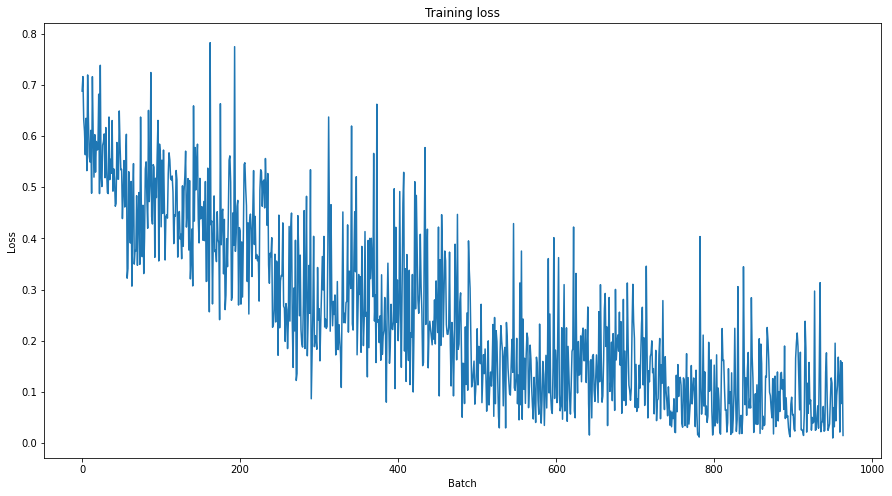

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#Predicting and evaluating using the holdout dataset 

The BERT downstream model was trained with the in_domain_train.tsv dataset.
The program will now make predictions using the holdout (testing) dataset
contained in the out_of_domain_dev.tsv file. The goal is to predict whether the
sentence is grammatically correct.

In [ ]:
df = pd.read_csv("/content/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

#Evaluating using Matthews Correlation Coefficient

The Matthews Correlation Coefficient (MCC) was initially designed to measure the
quality of binary classifications and can be modified to be a multi-class correlation
coefficient. A two-class classification can be made with four probabilities at each
prediction:

• TP = True Positive

• TN = True Negative

• FP = False Positive

• FN = False Negative

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


#The score of individual batches

In [ ]:
matthews_set

[0.049286405809014416,
 -0.21684543705982773,
 0.4732058754737091,
 0.23372319715296222,
 0.24816038707378335,
 0.7410010097502685,
 0.4526019054848144,
 0.47519096331149147,
 0.8320502943378436,
 0.8805899139163632,
 0.9229582069908973,
 0.7419408268023742,
 0.8150678894028793,
 0.7141684885491869,
 0.1794871794871795,
 0.49382916465843113,
 0.0]

#Matthews evaluation for the whole dataset

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5347221406301049